In [36]:
#import the libraries
#plotting libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import plotly.graph_objects as go
import plotly.offline as pyo
import matplotlib.cm as cm
#models libraries

from yellowbrick.cluster import KElbowVisualizer
import pylab as pl
from sklearn import cluster
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import scipy.cluster.hierarchy as hcd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_samples, silhouette_score
#from sklearn.cluster import DBSCAN


#import hdbscan

#features will be usig along the process
features = [
    'danceability',
    'energy',
    #'key',
    'loudness',
    #'mode',
    'acousticness',
    #'liveness',
    'valence',
    'tempo',
    #'duration_ms',
    #'time_signature'
]
spotify = [
    'danceability',
    'energy',
    #'key',
    #'loudness',
    #'mode',
    'acousticness',
    'liveness',
    'valence',
    #'tempo',
    #'duration_ms',
    #'time_signature'
]
musicology= [
    #'danceability',
    #'energy',
    'key',
    'loudness',
    'mode',
    #'acousticness',
    #'liveness',
    #'valence',
    'tempo',
    #'duration_ms',
    'time_signature'
]
# Some variables


NUM_CLUSTERS = 3  # k
NUM_ITER = 3          # n
NUM_ATTEMPTS = 5      # m
INIT='k-means++'

In [2]:
#define data scaling class for using the standard scaler
class data_scaler:
    
    def __init__(self, file):
#creates train and test dataframe
        self.df = self._load_data(file)
        
    def _load_data(self, file):
        return pd.read_csv(file)
    
    def dataset_info(self, file):
#prints main information
        df = self._load_data(file)
        print('\n{0:*^80}'.format(' Reading from the file {0} '.format(file)))
        print("\nit has {0} rows and {1} columns".format(*df.shape))
        print('\n{0:*^80}\n'.format(' It has the following columns '))
        print(df.columns)
        print('\n{0:*^80}\n'.format(' Description of quantitative columns'))
        print(df.describe(include=[np.number]))
        print('\n{0:*^80}\n'.format(' Description of categorical columns'))
        print(df.describe(include=['O']))
        
        
    def standard_scaler(self, df):
        scaled = StandardScaler().fit_transform(df)
        df_scaled = pd.DataFrame(scaled, columns=df.columns)
        return df_scaled

In [3]:
#Define clustering class

#k-means clustering
class clustering_methods:
    def k_means(self, df, n_clusters,init,max_iter,n_init,verbose):
        kmeans = KMeans(n_clusters=n_clusters,init=init,max_iter=max_iter,n_init=n_init,verbose=verbose )
        df['cluster'] = kmeans.fit_predict(df[df.columns])
        return df
    
#Hierarchical Agglomerative Clustering       
    def aggolmerative_clustering(self, df, n_clusters, affinity, linkage):
        agglom = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
        df['cluster'] = agglom.fit_predict(df)
        return df
    
#Dencity Based Clustering
    def density_based_clustering(self, df, eps, metric, min_samples):
        '''predict clusters using dbscan'''
        dbscan_df = DBSCAN(eps=eps, metric=metric, min_samples=min_samples).fit(df)
        labels = dbscan_df.labels_
        df["cluster"] = dbscan_df.fit_predict(df)                                                              
        return df
    def hierarchical_density_based_clustering(self, df, min_cluster_size, gen_min_span_tree=True):
#predict clusters using hdbscan'''
        clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, gen_min_span_tree=gen_min_span_tree)
        clusterer_hdbscan.fit(df)
        df["cluster"] = clusterer_hdbscan.fit_predict(df) 
        return df


In [4]:
#Define dimensonality reduction class, for visualizing the data

class dimensionality_reduction:
    def pca_transform(self, df_scaled, n_components):
#dimentionality reduction using pca'''
        pca = PCA(n_components=n_components)
        pcomponents = pca.fit_transform(df_scaled)
        pca_df = pd.DataFrame(pcomponents, columns = ['PC1', 'PC2'])
        ratio = pca.explained_variance_ratio_
        return pca_df, ratio
        
        
    def tsne_transform(self, df_scaled, n_components):
        tsne_transform = TSNE(n_components= n_components).fit_transform(df_scaled)
        return tsne_transform
    
    

In [5]:
#Define visualization class

class visualization:
#define the function that creates the basic model 
    def __init__(self):
        sns.set(rc={'figure.figsize': (11.7, 6.27)})
        self.palette = "viridis"
        self.color = "darkblue"
    
    
    
     
    def plot_elbow_curve(self, df, num):
#plot elbow curve to choose number of clusters
        k = range(1, num)
        kmeans = [KMeans(n_clusters=i) for i in k]
        score = [kmeans[i].fit(df[df.columns]).score(df[df.columns]) for i in range(len(kmeans))]
        pl.plot(k, score)
        pl.xlabel('Number of Clusters')
        pl.ylabel('Score')
        pl.title('Elbow Curve')
        pl.show()
        
    def plot_pca(self, pca_df, df, cluster_column):
#scatterplot to visualize after pca transformation
        sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=df[cluster_column], palette=self.palette)
        plt.xlabel('First principle component')
        plt.ylabel('Second principle component')
        plt.show()


    def plot_tsne(self, tsne_df, df, cluster_column):
#scatterplot to visualize after tsne transformation
        sns.scatterplot(x=tsne_df[:, 0], y=tsne_df[:, 1], hue=df[cluster_column], palette=self.palette)
        plt.xlabel('First tsne component')
        plt.ylabel('Second tsne component')
        plt.show()
        
    def plot_dendrogram(self, df, metric, method):
#plot dendrogram to choose number of clusters
        plt.style.use('ggplot')
        hcd.set_link_color_palette(["#B061FF", "#7a0177"])
        dendrogram = hcd.dendrogram(hcd.linkage(df, metric=metric, method=method))
        plt.title('Dendrogram', size=12)
        plt.xlabel('Songs', size=12)
        plt.ylabel('Euclidean Distances', size=12)
        plt.show()
        
    def plot_clusters(self, df, cluster):
#plot clusters interpretation
        sns.set_style("whitegrid")
        bins = np.linspace(0,2,10)
        fig, ax = plt.subplots(1, 6, figsize=(15, 3))
        cluster_df = df[df.cluster == cluster]
        cluster_features = ['acousticness', 'danceability', 'loudness', 'energy', 'tempo','valence']
        col = 0
        for feature in cluster_features:
            general = df.groupby(pd.cut(df[feature], bins)).size().reset_index(name='count')
            cluster = cluster_df.groupby(pd.cut(cluster_df[feature], bins)).size().reset_index(name='count')
            sns.barplot(data=general, x=feature, y='count', color='#efedf5', ax=ax[col])
            sns.barplot(data=cluster, x=feature, y='count', color='#224d55', ax=ax[col])
            ax[col].set_xticklabels(range(1,10), fontsize=10)
            col += 1
        plt.show()    


In [24]:
#Read the dataframe that has all the Spotify and Musicology features set
all_features_df = pd.read_csv ('/home/asmaosman/Music/Thesis files/Clusters_dataframes/all_features_dataframe.csv',  index_col = 0)
all_features_df.head()

,danceability,energy,key,loudness,mode,acousticness,liveness,valence,tempo,time_signature
track_id,,,,,,,,,,
0,0.317,0.386,9,-13.066,1,0.97,0.1630,0.782,100.796,4
1,0.527,0.444,11,-13.708,1,0.66,0.4140,0.725,124.681,4
2,0.494,0.170,4,-20.979,0,0.70,0.0875,0.314,155.024,1
3,0.322,0.630,10,-9.473,0,0.92,0.1160,0.758,102.394,3
4,0.737,0.704,4,-7.925,0,0.31,0.1060,0.737,139.985,4


In [25]:
#Exclude the unwanted axes 
clustering_df = all_features_df.drop(['mode','time_signature','key','liveness'], axis=1)
clustering_df 

,danceability,energy,loudness,acousticness,valence,tempo
track_id,,,,,,
0,0.317,0.386,-13.066,0.97,0.782,100.796
1,0.527,0.444,-13.708,0.66,0.725,124.681
2,0.494,0.170,-20.979,0.70,0.314,155.024
3,0.322,0.630,-9.473,0.92,0.758,102.394
4,0.737,0.704,-7.925,0.31,0.737,139.985
...,...,...,...,...,...,...
669,0.481,0.730,-8.289,0.73,0.941,71.326
670,0.588,0.713,-7.456,0.09,0.857,153.968
671,0.575,0.269,-22.835,0.53,0.761,110.744


In [26]:
#assign variables to each class
clustering = clustering_methods()
dimension = dimensionality_reduction()
plot = visualization()

In [27]:
#scale the data using the standard scaler
#please check if I did the standardization correctly as it's an essential step

scaled_data =data_scaler.standard_scaler(clustering_df  ,clustering_df  )
scaled_data.head(10)

,danceability,energy,loudness,acousticness,valence,tempo
0,-1.682965,-0.838945,-0.459427,1.603070,-0.013596,-0.874891
1,-0.261666,-0.556711,-0.568140,0.442805,-0.374817,-0.093805
2,-0.485013,-1.890025,-1.799365,0.592516,-2.979410,0.898470
3,-1.649124,0.348386,0.148988,1.415930,-0.165689,-0.822633
4,1.159633,0.708478,0.411117,-0.867173,-0.298770,0.406665
5,-0.058623,-0.318271,0.715918,-0.680033,-3.087143,-0.574098
6,1.058111,-0.036037,0.584345,-1.466019,-0.083305,0.144592
7,-0.221057,0.883658,0.270231,0.929367,0.917974,1.223821
8,-0.268434,-1.213636,-1.651536,0.330521,0.315939,-0.350025
9,0.367766,0.557629,0.828355,1.266219,1.038381,0.537800


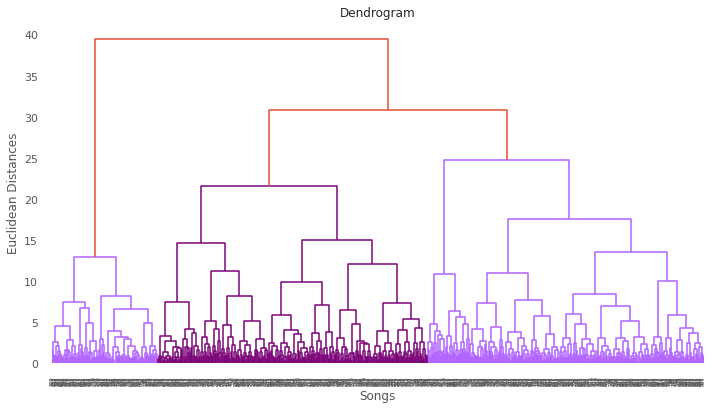

In [28]:
#Apply agglomerative clustering to determine the numbers of k for k-means, Euclidean and ward are commonly
#used that's why I applied them

plot.plot_dendrogram(scaled_data, 'euclidean', 'ward')


In [54]:
#The dendrogram above says 3 clusters as far as I can read
hc_df = clustering. aggolmerative_clustering(scaled_data, 3, 'euclidean', 'ward')
hc_df.cluster.unique()

array([1, 2, 0])

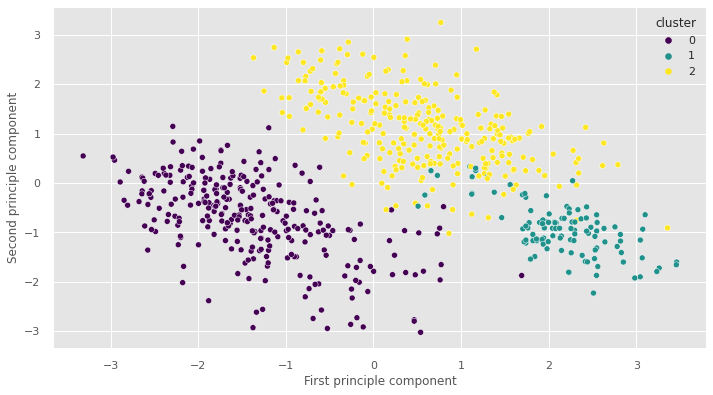

In [30]:
#This is applied for nothing but feature space visualization, commonly used for viz too, it gives a hint on the separation
hc_df_transform, ratio = dimension.pca_transform(hc_df, 2)
plot.plot_pca(hc_df_transform, hc_df, 'cluster')

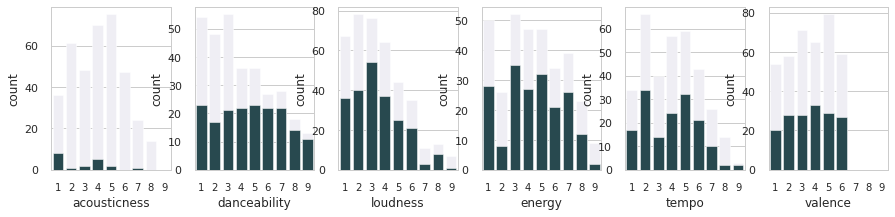

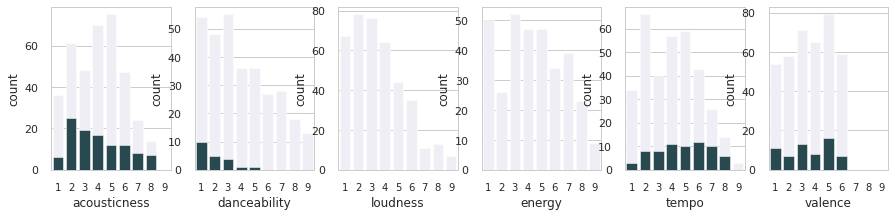

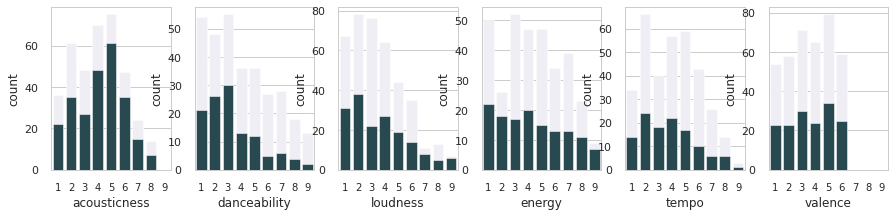

In [31]:
#this histogram i was hoping to use for giving me a hint on how the clusters are different in terms of features
#distribution
for i in np.sort(hc_df['cluster'].unique()):
    plot.plot_clusters(hc_df, i)

In [107]:
#Radar chart to check how clusters are separate or not
#I need to customize the labels, this is still a template but it gives a hint too


biggest_cluster=hc_df.groupby(['cluster']).count().max().max()

clusters = hc_df.cluster

fig = go.Figure()

for cluster in np.unique(clusters):
    
    radii = hc_df.loc[hc_df.cluster==cluster, features].mean().tolist()
    thetas = features
    
    actual_values = hc_df.loc[hc_df.cluster==cluster, features].mean().tolist()
    cluster_size = len(hc_df[hc_df.cluster==cluster])
    print(cluster_size)
    fig.add_trace(
        go.Scatterpolar(
            r=radii + radii[:1],
            theta=thetas + thetas[:1],
            mode='lines',
            name=f'Cluster {cluster}',
            text = [f'Mean value: {x}' for x in actual_values + actual_values[:1]],
            line=dict(width=3),
            opacity=np.max([cluster_size/biggest_cluster, 0.6])
        )
    )

fig.update_layout(
    title='Cluster Analysis',
    showlegend=True,
    template="plotly_dark",
    width=800,
    autosize=False
)

fig.show()

286
278
110


In [108]:
#Qucik check on how the metrics were 
#km = KMeans(n_clusters=NUM_CLUSTERS, init='random', max_iter=1, n_init=1)#, verbose=1)
#km.fit(hc_df)

#print('Pre-clustering metrics')
#print('----------------------')
#print('Inertia:', km.inertia_)
#print('Centroids:', km.cluster_centers_)

In [109]:
#This step is to extract final centroids and final inertia to be fed for the final clustering as model parameters


final_cents = []
final_inert = []


for sample in range(NUM_ATTEMPTS):
    print('\nCentroid attempt: ', sample)
    km = KMeans(n_clusters=NUM_CLUSTERS, init='random', max_iter=50, n_init=1, verbose=1)
    km.fit(hc_df)
    
    inertia_start = km.inertia_
    intertia_end = 0
    cents = km.cluster_centers_
        
    for iter in range(NUM_ITER):
        km = KMeans(n_clusters=NUM_CLUSTERS, init='random', max_iter=50, n_init=1, verbose=1)
        km.fit(hc_df)

        print('Iteration: ', iter)
        print('Inertia:', km.inertia_)
        print('Centroids:', km.cluster_centers_)
        inertia_end = km.inertia_
        cents = km.cluster_centers_

    final_cents.append(cents)
    final_inert.append(inertia_end)
    print('Difference between initial and final inertia: ', inertia_start-inertia_end)


Centroid attempt:  0
Initialization complete
Iteration 0, inertia 4308.6092074077
Iteration 1, inertia 2889.0639856879006
Iteration 2, inertia 2845.0426302833375
Iteration 3, inertia 2810.7887365135766
Iteration 4, inertia 2766.765239556734
Iteration 5, inertia 2727.7194653844526
Iteration 6, inertia 2713.247578865561
Iteration 7, inertia 2709.0479491813903
Iteration 8, inertia 2707.4182234533605
Iteration 9, inertia 2706.5402824123057
Iteration 10, inertia 2706.2527561592597
Iteration 11, inertia 2706.1536248945795
Converged at iteration 11: strict convergence.
Initialization complete
Iteration 0, inertia 4164.737855884288
Iteration 1, inertia 3012.818130848254
Iteration 2, inertia 2890.8550288424085
Iteration 3, inertia 2865.9568884549235
Iteration 4, inertia 2851.45669239096
Iteration 5, inertia 2842.6073651429942
Iteration 6, inertia 2838.951249593587
Iteration 7, inertia 2837.535409106838
Iteration 8, inertia 2836.9859593150586
Iteration 9, inertia 2836.874455185616
Iteration 10,

Iteration 2, inertia 2893.719640964577
Iteration 3, inertia 2865.882427828881
Iteration 4, inertia 2857.834941302038
Iteration 5, inertia 2849.5961589287435
Iteration 6, inertia 2843.210192007935
Iteration 7, inertia 2839.0250129661363
Iteration 8, inertia 2833.8488250034825
Iteration 9, inertia 2830.1602707825095
Iteration 10, inertia 2828.79092132137
Iteration 11, inertia 2827.7639512936803
Iteration 12, inertia 2827.545757208586
Iteration 13, inertia 2827.4681761756024
Converged at iteration 13: strict convergence.
Iteration:  0
Inertia: 2827.468176175603
Centroids: [[ 0.36525745 -0.21306244  0.0155419  -0.89685692 -1.32124638 -0.15972005
   0.13793103]
 [-0.59972415 -1.00805035 -1.0212473   0.76155112  0.0275518  -0.08120418
   1.50232558]
 [ 0.25239308  0.7039244   0.63488429 -0.1740469   0.42956543  0.10491669
   0.46355685]]
Initialization complete
Iteration 0, inertia 3973.886162219671
Iteration 1, inertia 2917.724768593188
Iteration 2, inertia 2879.926032602813
Iteration 3, in

In [40]:
# Get best centroids to use for full clustering
best_cents = final_cents[final_inert.index(min(final_inert))]
best_cents

array([[-1.48347294e-01,  2.57084047e-01,  3.79544648e-01,
         6.90302178e-01,  1.33938404e-01, -1.82987003e-01,
         1.98418972e+00],
       [-6.39228654e-01, -1.28686745e+00, -1.41427019e+00,
         6.51817569e-01, -2.85807833e-01,  1.21809633e-01,
         1.06493506e+00],
       [ 5.09262465e-01,  4.98634173e-01,  4.56077951e-01,
        -1.03006126e+00,  3.79325468e-02,  1.03134937e-01,
        -1.44328993e-15]])

In [134]:
#Feed the model with the dendrogram number of clusters and best centroids extracted above
#Feed the model with the dataframe produced by the hierarchical model, because hierarchical model does the basic
#linking between the members so the k-means doesn't have to initiate centroid assignment from scratch

km_full = KMeans(n_clusters=NUM_CLUSTERS, init=best_cents, max_iter=50, verbose=1, n_init=1)
cluster_labels= km_full.fit_predict(hc_df)
hybrid_df = pd.DataFrame(cluster_labels)
scaled_data['cluster']=hybrid_df

Initialization complete
Iteration 0, inertia 3563.728940412118
Iteration 1, inertia 2681.2491717715147
Iteration 2, inertia 2669.5514212562653
Iteration 3, inertia 2668.503241446574
Iteration 4, inertia 2668.462811719987
Converged at iteration 4: strict convergence.


In [42]:
#clusterer = KMeans(n_clusters=4, random_state=10)
#cluster_labels = clusterer.fit_predict(hc_df)

For n_clusters = 3 The average silhouette_score is : 0.21704088077491812


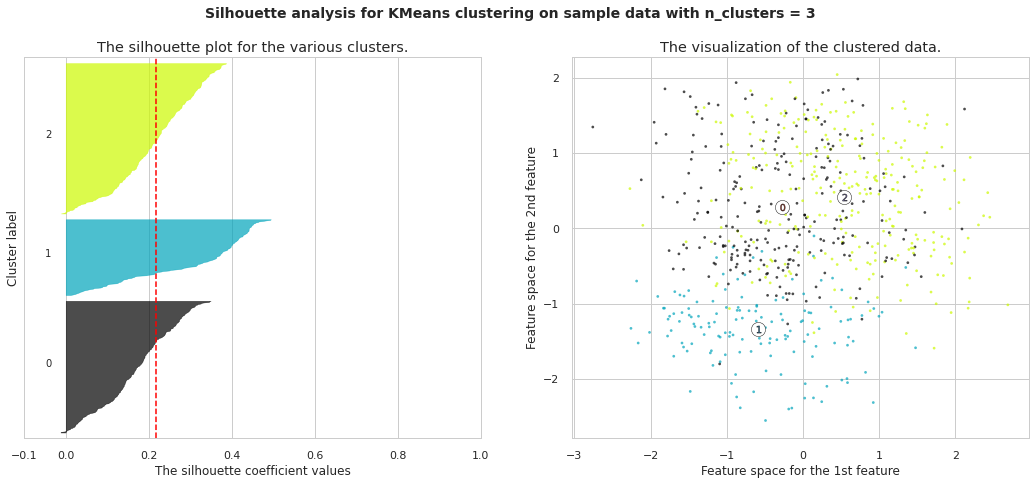

<Figure size 432x288 with 0 Axes>

In [58]:
#I'm trying to apply this chart to understand the silhouette score for the selected no.of clusters
#The feature space chart was an addition with the code, I still don't know how to benefit from it
#On the left, you can see that there are some negatives in cluster 0, in black

range_n_clusters = [3]
i=0
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(hc_df.iloc[:, 0], hc_df.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig('/home/asmaosman/Music/Thesis files/Figures/silhouette'+str(i)+'.png',dpi=300)

plt.show()
#plt.savefig('/home/asmaosman/Music/Thesis files/Figures/silhouette.png',dpi=300)


In [135]:
 biggest_cluster=scaled_data.groupby(['cluster']).count().max().max()

clusters = scaled_data.cluster

fig = go.Figure()

for cluster in np.unique(clusters):
    
    radii = scaled_data.loc[scaled_data.cluster==cluster, features].mean().tolist()
    thetas = features
    
    actual_values = scaled_data.loc[scaled_data.cluster==cluster, features].mean().tolist()
    cluster_size = len(scaled_data[scaled_data.cluster==cluster])
    print(cluster_size)
    fig.add_trace(
        go.Scatterpolar(
            r=radii + radii[:1],
            theta=thetas + thetas[:1],
            mode='lines',
            name=f'Cluster {cluster}',
            text = [f'Mean value: {x}' for x in actual_values + actual_values[:1]],
            line=dict(width=3),
            opacity=np.max([cluster_size/biggest_cluster, 0.6])
        )
    )

fig.update_layout(
    title='Cluster Analysis',
    showlegend=True,
    template='plotly_dark',
    width=800,
    autosize=False
)

fig.show()


191
210
273


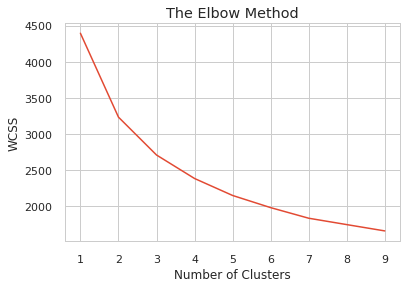

In [111]:
'''PART TWO'''
#Determine the number of k by Elbow, to apply only kmeans model on the data, not hybrid
#I give it  a random range, according to what I want, I don't want more than 4 clusters
#Is it 2 or 3? the obvious bend is on 2 but there's another light bend on 3, so there's a big difference in inertia score here


range_n_clusters = [2,3,4]
wcss=[]
for i in range(1,10):
    kmeans=KMeans(n_clusters=i, init='k-means++',random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,10),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [123]:
#Let's say 2 clusters according to Elbow, but look at the Silhouette score below
#km_full = KMeans(n_clusters=2, max_iter=50, verbose=1, n_init=1)
cluster_labels= km_full.fit_predict(hc_df)
#km_df= pd.DataFrame(cluster_labels)
kmeans_df = clustering.k_means(hc_df, n_clusters=2, init=INIT,max_iter=50,n_init=1,verbose=1)


Initialization complete
Iteration 0, inertia 5135.428470673352
Iteration 1, inertia 3516.0008497668564
Iteration 2, inertia 3295.1380126993663
Iteration 3, inertia 3249.9424122942037
Iteration 4, inertia 3234.7296141449674
Iteration 5, inertia 3232.8383003920153
Iteration 6, inertia 3232.279631337311
Converged at iteration 6: center shift 4.4390968004216565e-05 within tolerance 9.313356386237184e-05.
Initialization complete
Iteration 0, inertia 5189.624921886667
Iteration 1, inertia 3710.69930921501
Iteration 2, inertia 3389.0494836447524
Iteration 3, inertia 3269.620131814989
Iteration 4, inertia 3242.6344897704867
Iteration 5, inertia 3236.5573299792763
Iteration 6, inertia 3234.8713669840363
Iteration 7, inertia 3233.3311530623673
Iteration 8, inertia 3232.780754485081
Iteration 9, inertia 3232.265473799609
Converged at iteration 9: strict convergence.


In [124]:
#all_features_df['cluster']=km_df
#all_features_df
#all_features_df.to_csv('/home/asmaosman/Music/Thesis files/Data_Exploratory_csv/features/hybrid_model_clusters.csv')

For n_clusters = 2 The average silhouette_score is : 0.2593159663361289
For n_clusters = 3 The average silhouette_score is : 0.1977463654014305
For n_clusters = 4 The average silhouette_score is : 0.2096263186546208


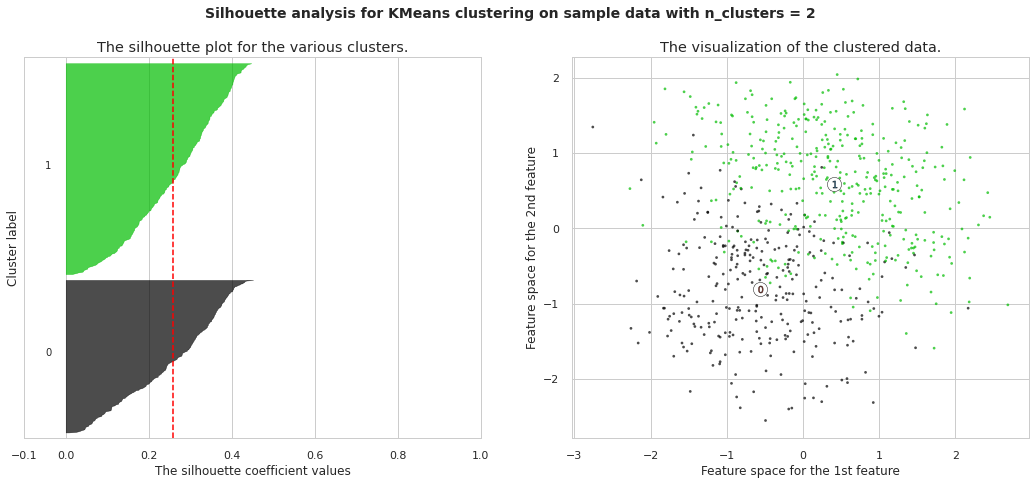

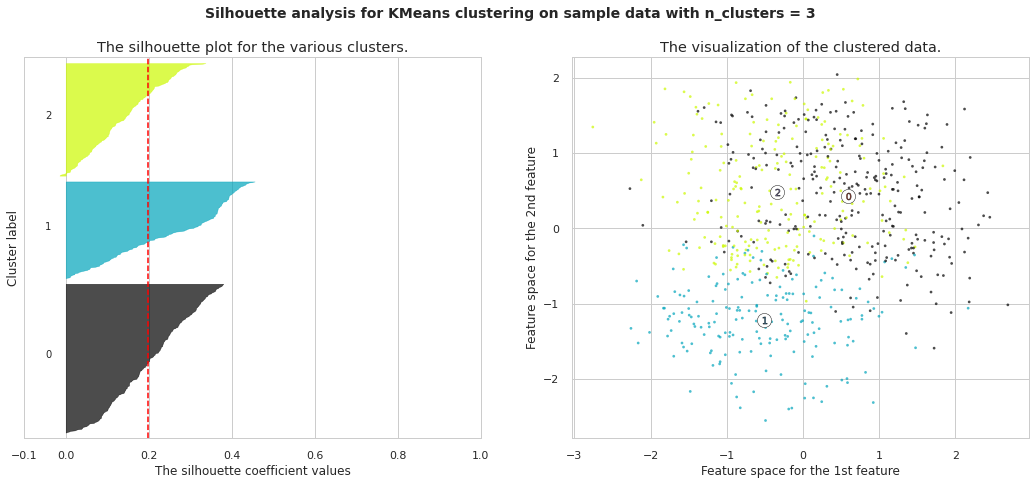

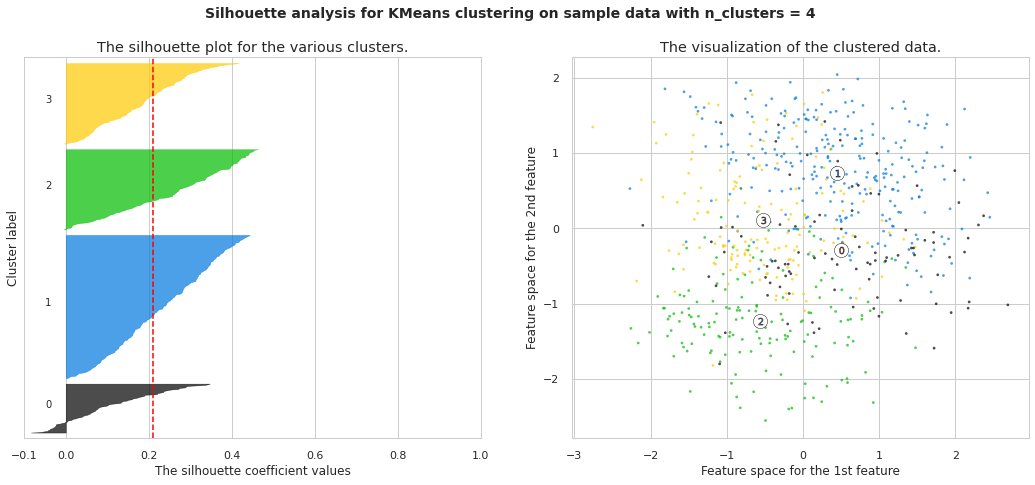

<Figure size 432x288 with 0 Axes>

In [125]:
#Slhouette score for 2 is higher

i=0
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cluster_labels) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(scaled_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(scaled_data.iloc[:, 0], scaled_data.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.savefig('/home/asmaosman/Music/Thesis files/Figures/silhouette'+str(i)+'.png',dpi=300)

plt.show()
plt.savefig('/home/asmaosman/Music/Thesis files/Figures/silhouette.png',dpi=300)


In [103]:
#This is just to save the clusters to the orginal features dataframe 
#all_features_df['cluster']=kmeans_df
#all_features_df
#all_features_df.to_csv('/home/asmaosman/Music/Thesis files/Data_Exploratory_csv/features/km_3_model_clusters.csv')

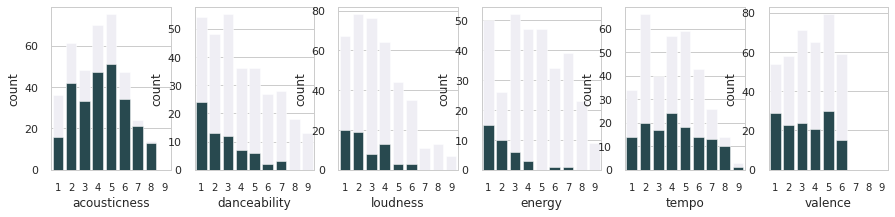

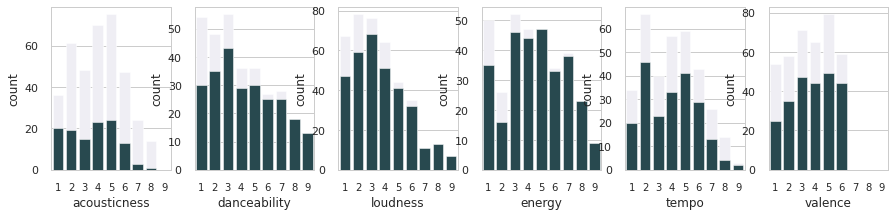

In [126]:
for i in np.sort(kmeans_df['cluster'].unique()):
    plot.plot_clusters(kmeans_df, i)

In [128]:
 biggest_cluster=kmeans_df.groupby(['cluster']).count().max().max()

clusters = kmeans_df.cluster

fig = go.Figure()

for cluster in np.unique(clusters):
    
    radii = kmeans_df.loc[kmeans_df.cluster==cluster, features].mean().tolist()
    thetas = features
    
    actual_values = kmeans_df.loc[kmeans_df.cluster==cluster, features].mean().tolist()
    cluster_size = len(kmeans_df[kmeans_df.cluster==cluster])
    print(cluster_size)
    fig.add_trace(
        go.Scatterpolar(
            r=radii + radii[:1],
            theta=thetas + thetas[:1],
            mode='lines',
            name=f'Cluster {cluster}',
            text = [f'Mean value: {x}' for x in actual_values + actual_values[:1]],
            line=dict(width=3),
            opacity=np.max([cluster_size/biggest_cluster, 0.6])
        )
    )

fig.update_layout(
    title='Cluster Analysis',
    showlegend=True,
    template='plotly_dark',
    width=800,
    autosize=False
)

fig.show()


282
392
